
# Analyzing Fairness and Bias in Crime Prediction Models

This tutorial investigates bias and fairness in predictive policing models. 
Using the Communities and Crime dataset, we explore the implications of using potentially imbalanced data and propose methods for improving fairness.
The main objectives are:

- Understand how bias manifests in the dataset and predictive models.
- Evaluate fairness metrics to measure the impact of these biases.
- Explore techniques to mitigate bias and assess their effectiveness.

Let's begin by exploring the dataset and understanding its structure.


In [ ]:
! pip install ucimlrepo
! pip install matplotlib
! pip install scikit-learn
! pip install seaborn

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings

In [2]:
# Silence all warnings
warnings.filterwarnings('ignore')

#### **Load Dataset**

In [4]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 

In [5]:
# Convert to a dataframe
df = pd.concat([X, y], axis=1)

df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [6]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Check for missing values again
print(df.isnull().sum())

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


### **Data Preprocessing**

The `community` column represents unique identifiers for each community. Although the values are numeric, they should not be treated as continuous or ordinal variables. This is because the numeric values in the `community` column are simply community identifiers, meaning there is no magnitude relationship between them. If we treated the `community` column as a continuous or ordinal variable, the Random Forest model could interpret comparisons like 17 > 2 or 17 - 2 = 15, which doesn't make sense in this context. The model could mistakenly compare these communities based on numeric values, leading to incorrect conclusions. For this reason, we will remove it.

The `communityname` column contains the names of the communities. This column is a categorical variable represented as text, meaning it needs to be converted to a numeric form to be used in models like Random Forest, which require numeric data to perform splits and calculations. The model cannot process strings directly, so we need to either remove or encode this variable before feeding it into the model. Otherwise, the algorithm would not know how to handle this text column. For this reason, we will remove it.

The `state` column is numeric and contains codes that represent the states where the communities are located. These codes are not ordinal, meaning there is no inherent order between them (for example, code 1 does not mean it is more "important" or "larger" than code 2). Since `state` is a categorical numeric variable (with codes representing states), the most appropriate technique to handle it is One-Hot Encoding. This transformation converts each state code into a new binary column (0 or 1), where each row indicates the presence or absence of a specific state for each community. Although `state` is numeric, this technique is used to prevent the model from incorrectly interpreting numeric codes as ordinal. The model could, inappropriately, try to compare state codes as if they were continuous or ordinal variables (for example, 1 > 2). Thus, One-Hot Encoding resolves this by treating each state as an independent category.



In [ ]:
# Drop features that are redundant or less relevant according to the domain knowledge
columns_to_drop = [
    'communityname', 
    'state', 
    'community', 
    'numbUrban',  # Keep only 'pctUrban'
    'NumIlleg',  # Keep 'PctIlleg'
    'PctImmigRec10', 'PctImmigRec5', 'PctImmigRec8',  # Keep 'PctRecImmig5' and 'PctRecImmig10'
    'PctSpeakEnglOnly',  # Keep 'PctNotSpeakEnglWell' PctSpeakEnglOnly
]

# Drop the unnecessary columns
df = df.drop(columns=columns_to_drop, errors='ignore')

In [8]:
# Remover as colunas com valores ausentes
df = df.dropna(axis=1)

#### **Remove correlation features**
- **Reduction of redundancy:** Highly correlated variables carry similar information. So, keeping both can increase dimensionality without adding value.

- **Improved interpretability:** Fewer features make the model easier to understand.

- **Avoiding overfitting:** High dimensionality and redundancy increase the risk of overfitting, especially with small datasets.

- **Reduced complexity:** Random Forest uses decision trees, which can become more complex with correlated variables.

- **Performance improvement:** By reducing redundancy, the model can converge more quickly and efficiently, improving accuracy.

- **Bias and fairness:** By removing variables related to sensitive attributes, we can mitigate potential biases in the model.

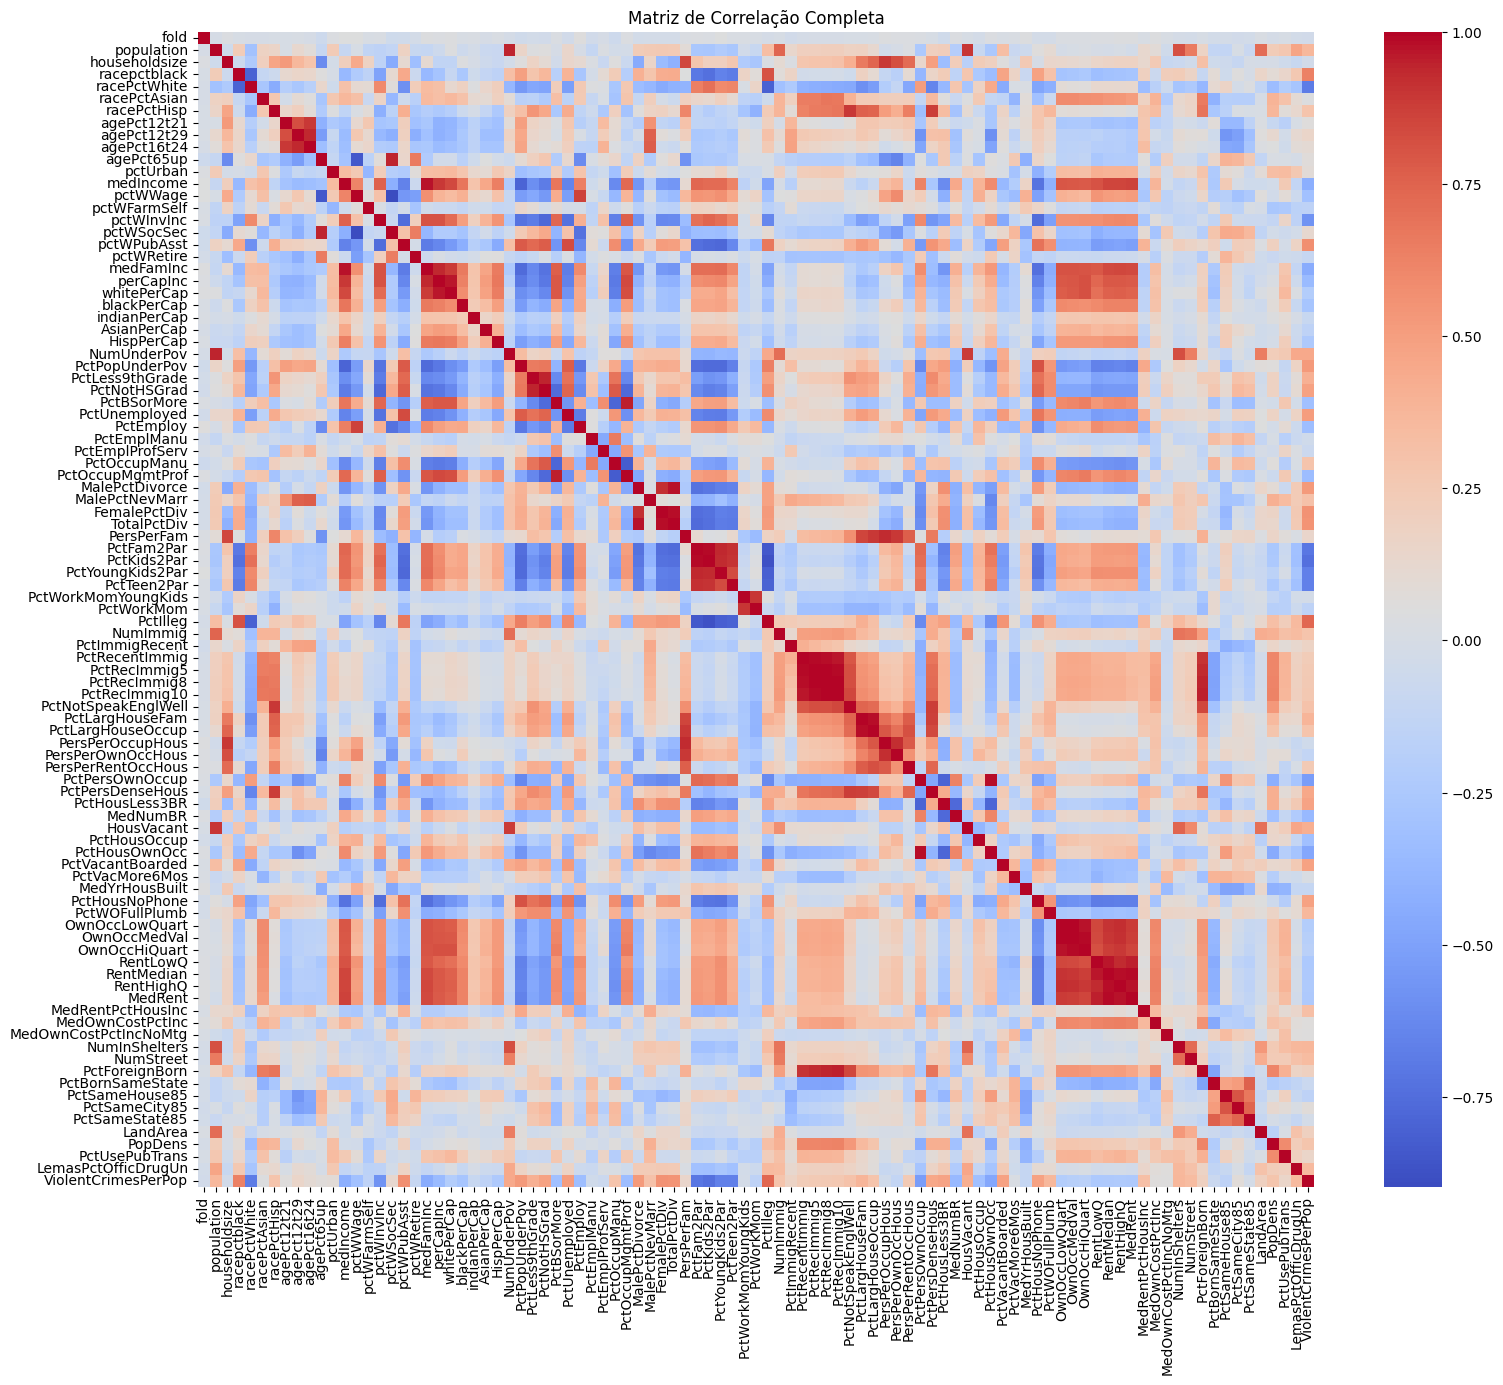

In [9]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

In [10]:
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

In [12]:
# Find and display columns to drop alongside the column they are highly correlated with
highly_correlated_pairs = []

for column in upper_triangle.columns:
    correlated_with = upper_triangle.index[upper_triangle[column] > 0.95].tolist()
    if correlated_with:
        for correlated_col in correlated_with:
            highly_correlated_pairs.append((correlated_col, column))  # Keep correlated_col, drop column

# Print the pairs (kept column, dropped column)
for keep, drop in highly_correlated_pairs:
    print(f"Keeping: {keep}, Dropping: {drop}")

Keeping: medIncome, Dropping: medFamInc
Keeping: perCapInc, Dropping: whitePerCap
Keeping: PctBSorMore, Dropping: PctOccupMgmtProf
Keeping: MalePctDivorce, Dropping: TotalPctDiv
Keeping: FemalePctDiv, Dropping: TotalPctDiv
Keeping: PctFam2Par, Dropping: PctKids2Par
Keeping: PctRecentImmig, Dropping: PctRecImmig5
Keeping: PctRecentImmig, Dropping: PctRecImmig8
Keeping: PctRecImmig5, Dropping: PctRecImmig8
Keeping: PctRecentImmig, Dropping: PctRecImmig10
Keeping: PctRecImmig5, Dropping: PctRecImmig10
Keeping: PctRecImmig8, Dropping: PctRecImmig10
Keeping: PctLargHouseFam, Dropping: PctLargHouseOccup
Keeping: PctPersOwnOccup, Dropping: PctHousOwnOcc
Keeping: OwnOccLowQuart, Dropping: OwnOccMedVal
Keeping: OwnOccLowQuart, Dropping: OwnOccHiQuart
Keeping: OwnOccMedVal, Dropping: OwnOccHiQuart
Keeping: RentLowQ, Dropping: RentMedian
Keeping: RentMedian, Dropping: RentHighQ
Keeping: RentMedian, Dropping: MedRent
Keeping: RentHighQ, Dropping: MedRent
Keeping: PctRecImmig10, Dropping: PctForeig

In [13]:
to_drop = list(set([pair[1] for pair in highly_correlated_pairs]))
to_drop = [feature for feature in to_drop if feature != 'WhitePerCap']

# Imprimir a lista final de colunas a serem removidas
print(f"Total de features a serem removidas: {len(to_drop)}")

Total de features a serem removidas: 16


In [14]:
# Criar um novo DataFrame removendo as features identificadas
df = df.drop(columns=to_drop, errors='ignore')

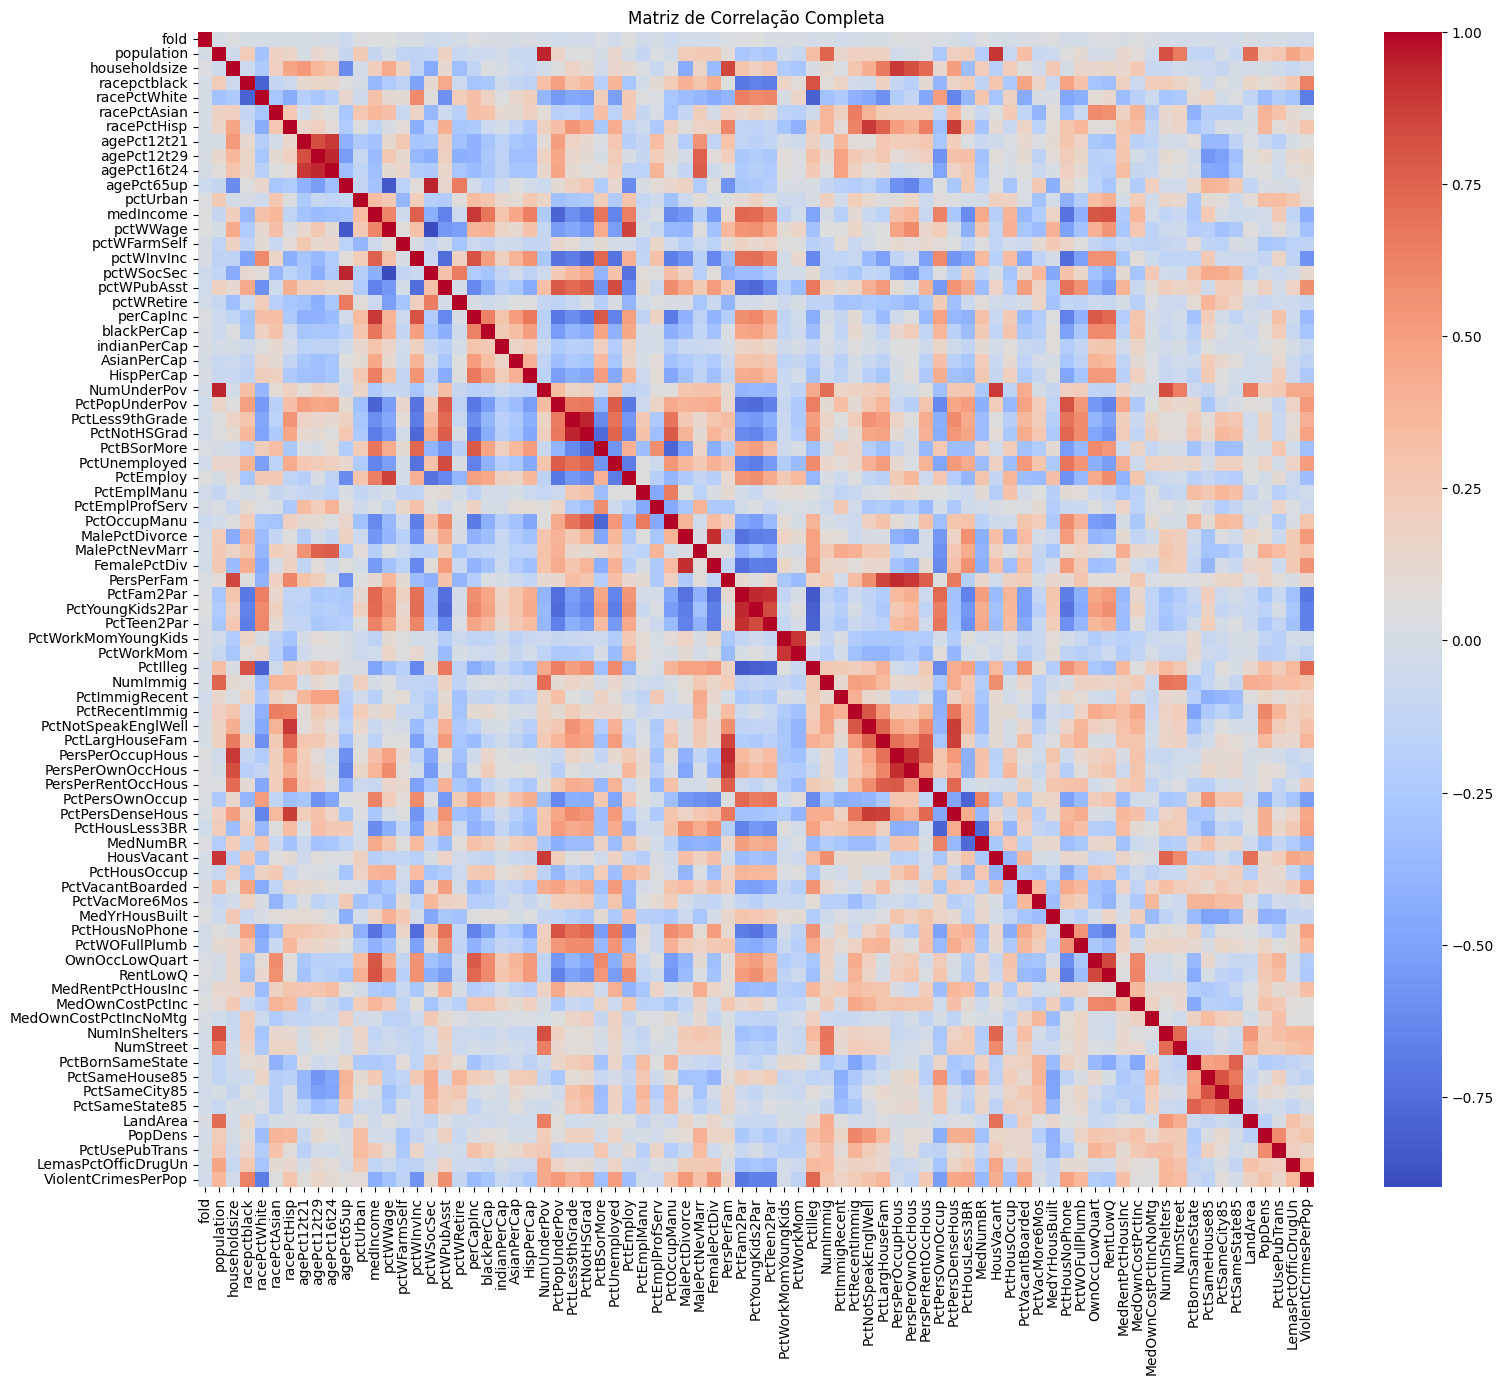

In [15]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

#### **Enconding Target Column**

In order to perform classification, we need to transform the continuous target column into a multi-class target column.

To do that, we define 2 intervals ( [0.0-0.5[, [0.5-1.0] ) and encode all 2 string intervals into numeric classes (0,1) so it would be easy to perform classification.

In [16]:
# Define the bins (intervals) and labels
bins = [0.0, 0.5, 1.0]  # Bin edges
labels = ['[0.0-0.5[', '[0.5, 1.0]']  # Class labels

# Transform the continuous column into a multi-class column
df['ViolentCrimesPerPop-Final'] = pd.cut(df['ViolentCrimesPerPop'], bins=bins, labels=labels, include_lowest=True)

In [17]:
# Encode the string intervals into numeric classes
label_encoder = LabelEncoder()
df['ViolentCrimesPerPop-Final'] = label_encoder.fit_transform(df['ViolentCrimesPerPop-Final'])

# Display mapping of classes
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'[0.0-0.5[': np.int64(0), '[0.5, 1.0]': np.int64(1)}


In [18]:
df = df.drop(columns=['ViolentCrimesPerPop'])

## **Model Predict**

#### **Demographic Analysis**

In [19]:
X = df.drop(columns= ['fold', 'ViolentCrimesPerPop-Final', 'racepctblack', 'racePctAsian', 'racePctHisp'], axis=1)
y = df['ViolentCrimesPerPop-Final']

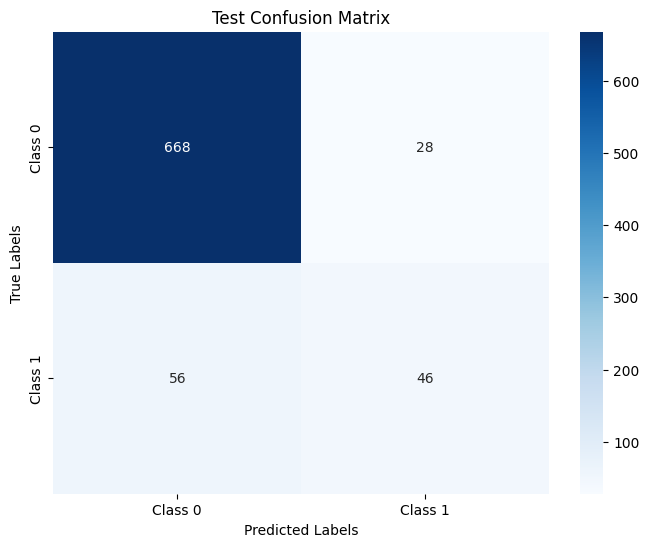

Test  -> Accuracy: 0.8947, Precision: 0.8842, Recall: 0.8947, F1: 0.8874


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

model = RandomForestClassifier(max_depth=10, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_labels = ["Class 0", "Class 1"]
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test  -> Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

With the obtained values we can do the following analysis:
- Accuracy: 0.8271: indicates that the model correctly predicts approximately 82.7% of the test samples.
- Precision: 0.8036: precision measures how many of the predicted positive cases are truly positive. The weighted average precision reflects class imbalances.
- Class 0: Predicted correctly 595 times, with minimal misclassification.
- Class 1: Underrepresented in correct predictions, with a high rate of misclassification.
This imbalance suggests potential fairness issues if these classes represent groups with demographic or social significance.

#### **Fairness Evaluation**

In [ ]:
! pip install aif360
! pip install tensorflow

In [22]:
from aif360.sklearn.datasets import fetch_compas
from aif360.sklearn.preprocessing import LearnedFairRepresentations
from aif360.sklearn.inprocessing import AdversarialDebiasing
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta

pip install 'aif360[FairAdapt]'
pip install 'aif360[inFairness]'
pip install 'aif360[OptimalTransport]'


In [26]:
# Transforming a dataset into a "fair representation" using a fairness-aware machine learning technique
Xt = LearnedFairRepresentations().fit_transform(X, y)

In [27]:
Xt

,population,householdsize,racePctWhite,agePct12t21,agePct12t29,agePct16t24,agePct65up,pctUrban,medIncome,pctWWage,...,NumInShelters,NumStreet,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.530014,0.559438,0.481933,0.475898,0.475093,0.413952,0.391736,0.330236,0.480426,0.530544,...,0.668109,0.454512,0.546433,0.424414,0.590728,0.362487,0.287727,0.635785,0.334976,0.413700
1,0.528595,0.549028,0.474303,0.470452,0.472176,0.418452,0.395915,0.332697,0.477188,0.538908,...,0.672872,0.448386,0.547485,0.426374,0.599526,0.355894,0.294262,0.638609,0.336859,0.417075
2,0.539230,0.549841,0.482198,0.480794,0.477429,0.413002,0.389564,0.320754,0.477138,0.530860,...,0.675186,0.438490,0.547562,0.429737,0.600664,0.364084,0.298821,0.638087,0.344859,0.422061
3,0.461150,0.518954,0.411392,0.441826,0.458024,0.450034,0.449388,0.374864,0.487469,0.581292,...,0.646627,0.475721,0.521708,0.451548,0.596848,0.315968,0.289301,0.649514,0.346215,0.431586
4,0.507097,0.545292,0.460218,0.448488,0.465796,0.424323,0.413061,0.364099,0.469486,0.554114,...,0.674847,0.475086,0.560657,0.407701,0.602812,0.343569,0.275660,0.650876,0.318986,0.402219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.512906,0.559088,0.470260,0.455711,0.465793,0.422137,0.401975,0.353806,0.477840,0.544461,...,0.667066,0.474283,0.551259,0.412824,0.590269,0.348840,0.276913,0.638514,0.316958,0.401118
1990,0.480011,0.536900,0.431387,0.436600,0.451288,0.446863,0.426568,0.369725,0.486752,0.574366,...,0.653544,0.474822,0.527716,0.437193,0.592586,0.318667,0.290262,0.635078,0.323253,0.414896
1991,0.524326,0.522800,0.458065,0.487225,0.482949,0.419430,0.411879,0.318977,0.477788,0.541791,...,0.671260,0.425634,0.537313,0.452785,0.611816,0.358050,0.310059,0.651080,0.375420,0.447044
1992,0.523266,0.546603,0.468748,0.465743,0.469186,0.422322,0.399442,0.337042,0.477923,0.543981,...,0.671388,0.450423,0.545316,0.427747,0.599794,0.350731,0.294877,0.638133,0.335111,0.417013


In [71]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [72]:
sensitive_features = X_train.iloc[:, 2]

In [73]:
sensitive_features.shape

(1196,)

In [74]:
y_train.shape

(1196,)

In [75]:
model = AdversarialDebiasing(prot_attr=sensitive_features)

In [76]:
model

AdversarialDebiasing(prot_attr=105     0.46
126     0.89
1128    0.74
834     0.99
355     0.83
        ... 
1130    0.68
1294    0.90
860     0.94
1459    0.61
1126    0.59
Name: racePctWhite, Length: 1196, dtype: float64)

In [77]:
model.fit(X_train, y_train)

AdversarialDebiasing(prot_attr=105     0.46
126     0.89
1128    0.74
834     0.99
355     0.83
        ... 
1130    0.68
1294    0.90
860     0.94
1459    0.61
1126    0.59
Name: racePctWhite, Length: 1196, dtype: float64)

In [78]:
y_pred = AdversarialDebiasing().fit(X_train, y_train).predict(X_test)

In [90]:
# Nao ta a funcionar

y_pred = PostProcessingMeta(
     LogisticRegression(),
     RejectOptionClassifierCV(prot_attr=None, scoring='disparate_impact')
).fit(X_train, y_train).predict(X_test)


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/work-IAS/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/work-IAS/lib/python3.9/site-packages/aif360/sklearn/postprocessing/reject_option_classification.py", line 116, in fit
    groups, self.prot_attr_ = check_groups(X, self.prot_attr,
  File "/opt/homebrew/Caskroom/miniforge/base/envs/work-IAS/lib/python3.9/site-packages/aif360/sklearn/utils.py", line 97, in check_groups
    raise ValueError("Expected 2 protected attribute groups, got "
ValueError: Expected 2 protected attribute groups, got Index([1830, 1432, 1504,  373, 1963, 1637, 1528,  338, 1631,   19,
       ...
         62,  499, 1294, 1399, 1605, 1850, 1574, 1942, 1207, 1297],
      dtype='int64', length=299)


In [39]:
X_test_with_preds = X_test.copy()
X_test_with_preds['y_test_true'] = y_test.values 
X_test_with_preds['y_test_pred'] = y_test_pred 

#### Grouping according to the percentage of white individuals

In [40]:
"""
Low White : there are not a lot of white people in the community
High White : There are a lot of white people in the community
"""

'\nLow White : there are not a lot of white people in the community\nHigh White : There are a lot of white people in the community\n'

In [41]:
X_test_with_preds['race_group'] = pd.cut(
    X_test_with_preds['racePctWhite'], 
    bins=[0.0, 0.5, 1.0], 
    labels=['Low White %', 'High White %'], 
    include_lowest=True
)

#### Problem overview

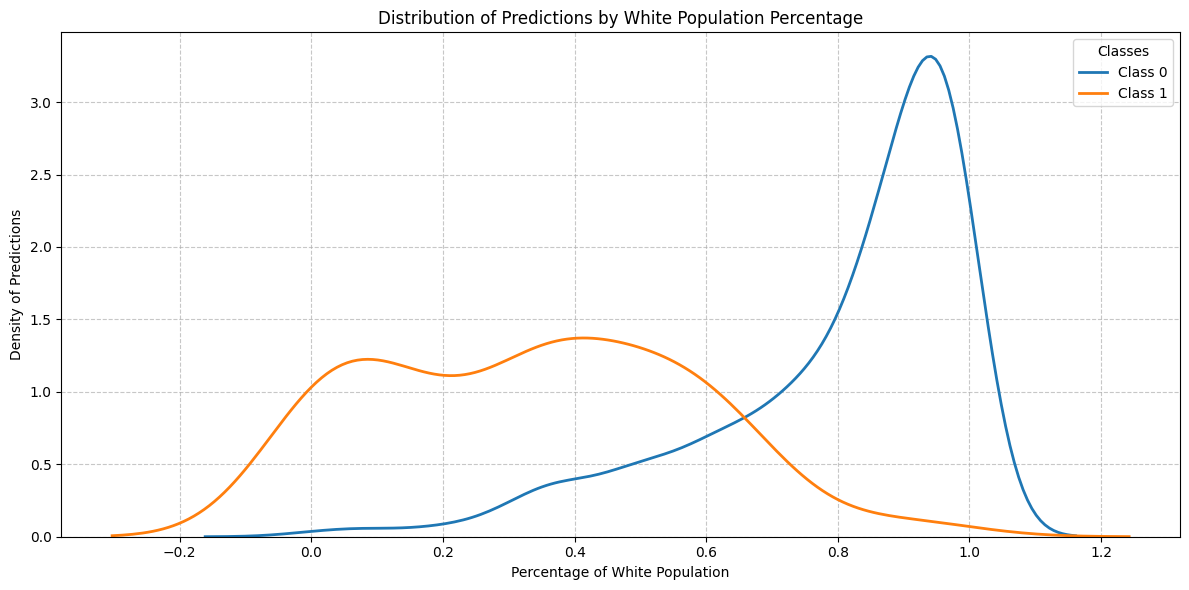

In [42]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_pred'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_pred'] == cls],
        x="racePctWhite",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of Predictions by White Population Percentage')
plt.xlabel('Percentage of White Population')
plt.ylabel('Density of Predictions')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

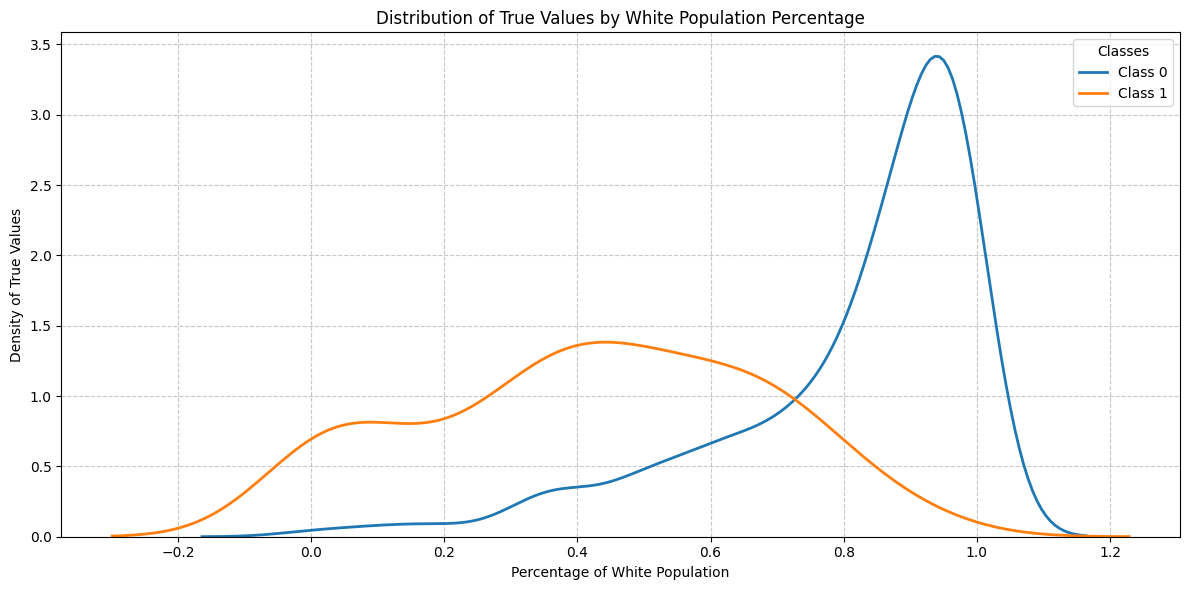

In [43]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_true'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_true'] == cls],
        x="racePctWhite",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of True Values by White Population Percentage')
plt.xlabel('Percentage of White Population')
plt.ylabel('Density of True Values')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Fairness Metrics

In [44]:
# Filtrar os dados para ignorar o grupo "Medium White %"
filtered_groups = ['Low White %', 'High White %']
filtered_data = X_test_with_preds[X_test_with_preds['race_group'].isin(filtered_groups)]

##### Accuracy Parity

In [45]:
# Calcular a precisão por grupo (apenas para os grupos Low White % e High White %)
accuracies = []
for group in filtered_data['race_group'].unique():
    group_data = filtered_data[filtered_data['race_group'] == group]
    group_accuracy = accuracy_score(group_data['y_test_true'], group_data['y_test_pred'])
    accuracies.append(group_accuracy)
    print(f"Accuracy for {group}: {group_accuracy:.4f}")

Accuracy for High White %: 0.9367
Accuracy for Low White %: 0.6866


The accuracy for the High White % group is 0.9207, indicating a high performance of the model when correctly classifying the samples in this group. In contrast, the accuracy for the Low White % group is considerably lower, 0.5441, suggesting that the model has more difficulty correctly classifying samples from this group. This disparity may be indicative of a bias in the model, which may be influenced by specific characteristics of the data related to the Low White % group.

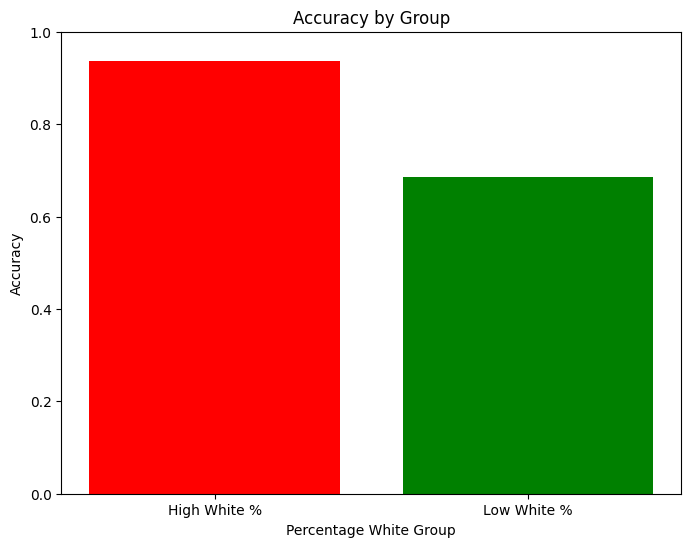

In [46]:
plt.figure(figsize=(8, 6))
plt.bar(filtered_data['race_group'].unique(), accuracies, color=['red', 'green'])
plt.xlabel('Percentage White Group')
plt.ylabel('Accuracy')
plt.title('Accuracy by Group')
plt.ylim(0, 1)
plt.show()

##### True Positive Rate and False Positive Rate

In [47]:
# Função para calcular as métricas TPR e FPR para problemas multiclasse
def calculate_metrics(y_true, y_pred, classes_to_consider):
    # Calcular a matriz de confusão usando todas as classes presentes nos dados
    cm = confusion_matrix(y_true, y_pred, labels=classes_to_consider)
    
    tpr_values = []
    fpr_values = []

    for i, class_label in enumerate(classes_to_consider):
        # TPR: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
        TPR = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) != 0 else 0
        
        # FPR: Falsos Positivos / (Falsos Positivos + Verdadeiros Negativos)
        FPR = np.sum(cm[:, i]) / np.sum(cm) if np.sum(cm[:, i]) != 0 else 0

        tpr_values.append(TPR)
        fpr_values.append(FPR)

    return tpr_values, fpr_values

In [48]:
# Classes que vamos analisar: 0 e 1
classes_to_consider = [0, 1]

# Inicializando listas para armazenar os valores de TPR e FPR para cada classe
tpr_values = {class_label: [] for class_label in classes_to_consider}
fpr_values = {class_label: [] for class_label in classes_to_consider}

# Filtrar os dados para considerar apenas os grupos Low White % e High White % e as classes 0 e 1
filtered_groups = ['Low White %', 'High White %']
filtered_data = X_test_with_preds[X_test_with_preds['race_group'].isin(filtered_groups)]

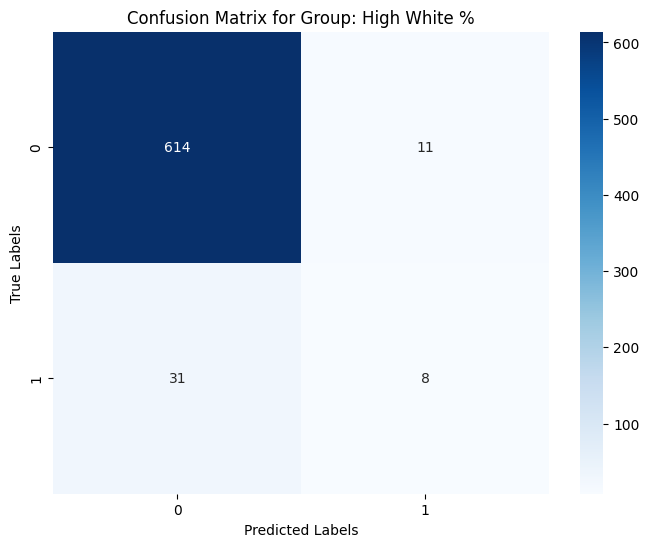

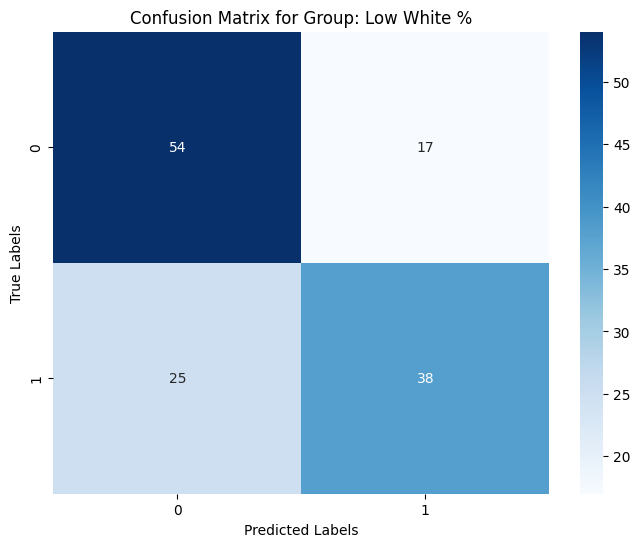

In [49]:
# Calcular TPR e FPR por classe e grupo
#for group in filtered_data['race_group'].unique():
#    group_data = filtered_data[filtered_data['race_group'] == group]
#    y_true = group_data['y_test_true']
#    y_pred = group_data['y_test_pred']
#    
#    # Calcular as métricas
#    tpr, fpr = calculate_metrics(y_true, y_pred, classes_to_consider)
#    
#    # Adicionar os valores das métricas por classe
#    for class_label in classes_to_consider:
#        tpr_values[class_label].append(tpr[classes_to_consider.index(class_label)])
#        fpr_values[class_label].append(fpr[classes_to_consider.index(class_label)])
#
## Imprimir os resultados de TPR e FPR
#for class_label in classes_to_consider:
#    print(f"Class {class_label}:")
#    for group, tpr, fpr in zip(filtered_data['race_group'].unique(), tpr_values[class_label], fpr_values[class_label]):
#        print(f"  Group: {group}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

# Plot the confusion matrix for each group
for group in filtered_data['race_group'].unique():
    group_data = filtered_data[filtered_data['race_group'] == group]
    y_true = group_data['y_test_true']
    y_pred = group_data['y_test_pred']
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes_to_consider)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes_to_consider, yticklabels=classes_to_consider)
    plt.title(f"Confusion Matrix for Group: {group}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

For Class 0:

- The High White % group has a TPR (True Positive Rate) of 1.0000, indicating perfect classification of all Class 0 instances as positive. However, the FPR (False Positive Rate) is also 1.0000, suggesting the model is identifying many false positives, or incorrectly classifying cases as Class 0. 
- In contrast, in the Low White % group, the TPR decreases to 0.6429, showing less accuracy in classification. The FPR (0.4516) remains high, indicating the model still makes significant errors, but to a lesser degree than in the High White % group.

For Class 1:

- The High White % group shows no correct predictions, with both TPR and FPR equal to 0, meaning the model completely fails to identify any instances of Class 1 in the group with a higher percentage of white people. 
- In the Low White % group, the model performs better with a TPR of 0.7059, indicating reasonable detection of Class 1, although the FPR (0.5484) is still relatively high, pointing to a considerable number of false positives.

These results highlight a bias in the model's performance, where it excels at correctly predicting low-risk cases (Class 0) in communities with a higher percentage of white individuals, while it struggles to accurately predict high-risk cases (Class 1), especially in such communities.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

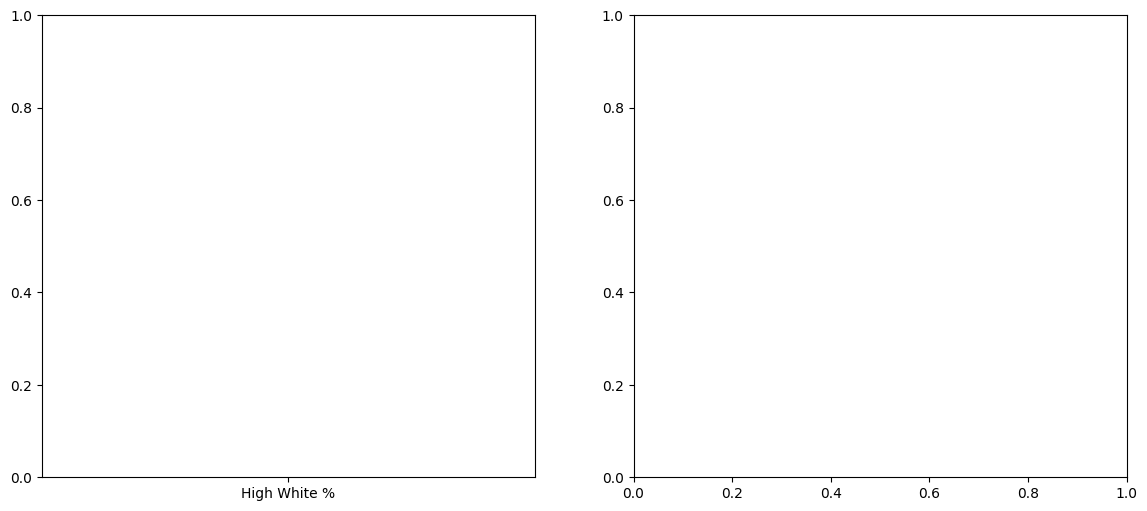

In [56]:
# Nao vi

# Criar gráfico de barras para TPR e FPR por grupo e classe
fig, axes = plt.subplots(1,2,figsize=(14, 6))

# Gráfico de TPR para classe 0
axes[0].bar(filtered_data['race_group'].unique(), tpr_values[0], label="Class 0")
axes[0].set_xlabel('Percentage White Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 0 by Group')
axes[0].legend()

# Gráfico de FPR para classe 0
axes[1].bar(filtered_data['race_group'].unique(), fpr_values[0], label="Class 0")
axes[1].set_xlabel('Percentage White Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 0 by Group')
axes[1].legend()

<Figure size 640x480 with 0 Axes>

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (0,).

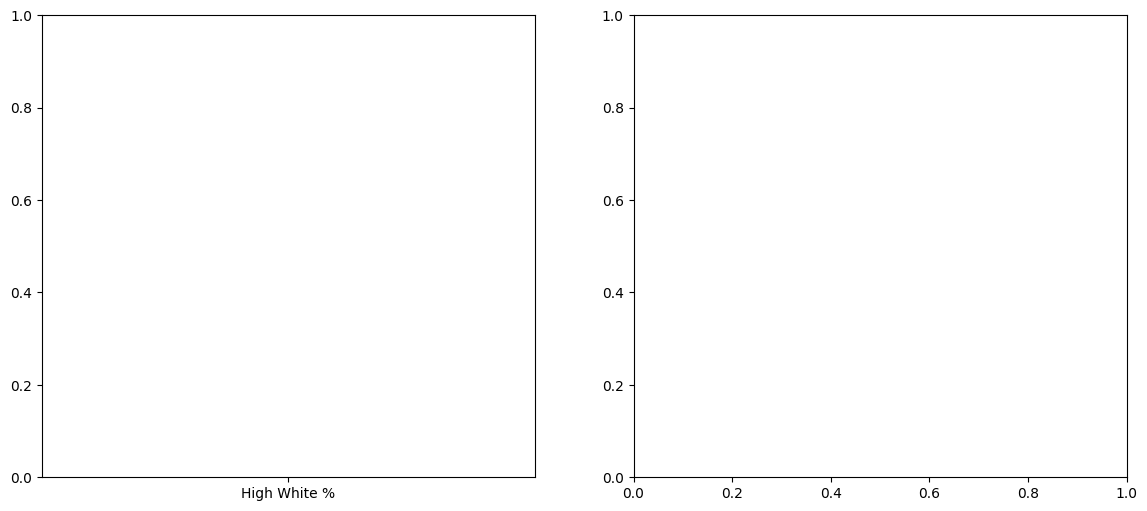

In [ ]:
# Nao vi

plt.tight_layout()
plt.show()

# Criar gráficos separados para TPR e FPR para a classe 1
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 1
axes[0].bar(filtered_data['race_group'].unique(), tpr_values[2], label="Class 1")
axes[0].set_xlabel('Percentage White Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 1 by Group')
axes[0].legend()

# Gráfico de FPR para classe 1
axes[1].bar(filtered_data['race_group'].unique(), fpr_values[2], label="Class 1")
axes[1].set_xlabel('Percentage White Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 1 by Group')
axes[1].legend()

plt.tight_layout()
plt.show()

##### Disparate Impact

In [ ]:
# Definir os grupos baseados na percentagem de brancos
group_protected = X_test_with_preds[X_test_with_preds['racePctWhite'] >= 0.5]
group_non_protected = X_test_with_preds[X_test_with_preds['racePctWhite'] < 0.5]

# Definir o resultado favorável (classe "low risk" = 0)
favorable_outcome = 0

# Calcular a proporção de resultados favoráveis para cada grupo
protected_favorable_rate = (group_protected['y_test_pred'] == favorable_outcome).mean()
non_protected_favorable_rate = (group_non_protected['y_test_pred'] == favorable_outcome).mean()

# Calcular o Disparate Impact
disparate_impact = protected_favorable_rate / non_protected_favorable_rate if non_protected_favorable_rate > 0 else 0

# Exibir os resultados
print("                      LOW-RISK   ")
print(f"Favorable Outcome Rate for High White %: {protected_favorable_rate:.4f}")
print(f"Favorable Outcome Rate for Low White %: {non_protected_favorable_rate:.4f}")
print(f"Disparate Impact: {disparate_impact:.4f}")

                      LOW-RISK   
Favorable Outcome Rate for High White %: 0.9688
Favorable Outcome Rate for Low White %: 0.5794
Disparate Impact: 1.6721


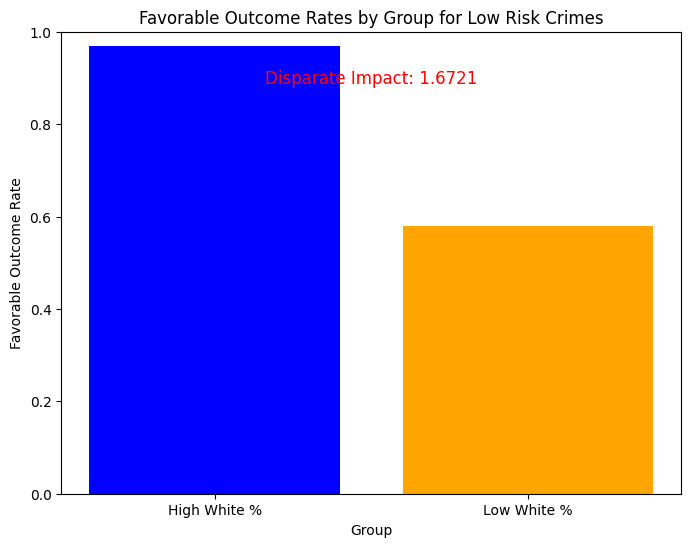

In [ ]:
# Data for visualization
groups = ['High White %', 'Low White %']
favorable_rates = [protected_favorable_rate, non_protected_favorable_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, favorable_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for Low Risk Crimes')
plt.xlabel('Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()


**Disparate Impact (DI): 3.7270**

**For Low-Risk:**

The favorable outcome rate for the **High White %** group is 0.9776, meaning that 97.76% of the cases in this group are classified as low risk. In contrast, the **Low White %** group has a much lower favorable outcome rate of 0.2623, indicating that only 26.23% of cases in this group are classified as low risk. The **Disparate Impact** is 3.7270, which indicates a significant disparity between the two groups. The model is much more likely to classify communities with a higher percentage of white people as low risk, while communities with a lower percentage of white people are less likely to be classified as low risk. This suggests that the model may be biased in favor of communities with a higher percentage of white individuals, potentially overestimating the number of low-risk cases in these communities.

In [ ]:
# Definir grupos de High Risk
high_risk_class = 1  # Classe "high risk" (assumindo que a classe 1 representa high risk)

# Identificar os grupos baseados na racePctWhite
group_high_white = X_test_with_preds[X_test_with_preds['racePctWhite'] >= 0.5]
group_low_white = X_test_with_preds[X_test_with_preds['racePctWhite'] < 0.5]

# Calcular as taxas de resultado favorável para o grupo High Risk
high_white_high_risk_rate = (group_high_white['y_test_pred'] == high_risk_class).mean()
low_white_high_risk_rate = (group_low_white['y_test_pred'] == high_risk_class).mean()

# Calcular o Disparate Impact (DI)
disparate_impact_high_risk = high_white_high_risk_rate / low_white_high_risk_rate

# Exibir os resultados
print("                      HIGH-RISK   ")
print(f"Favorable Outcome Rate for High White %: {high_white_high_risk_rate:.4f}")
print(f"Favorable Outcome Rate for Low White %: {low_white_high_risk_rate:.4f}")
print(f"Disparate Impact (High Risk): {disparate_impact_high_risk:.4f}")

                      HIGH-RISK   
Favorable Outcome Rate for High White %: 0.0312
Favorable Outcome Rate for Low White %: 0.4206
Disparate Impact (High Risk): 0.0743


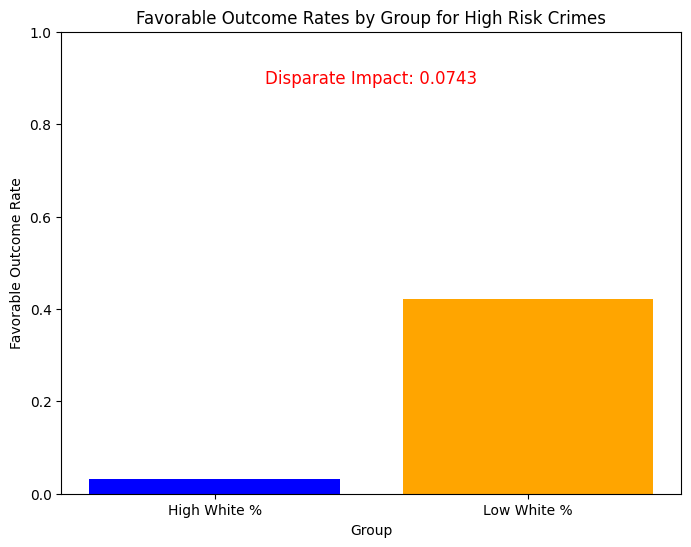

In [ ]:
# Data for visualization
groups = ['High White %', 'Low White %']
high_risk_rates = [high_white_high_risk_rate, low_white_high_risk_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, high_risk_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for High Risk Crimes')
plt.xlabel('Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact_high_risk:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 0.0048**

**For High-Risk:**

The favorable outcome rate for the **High White %** group is 0.0017, which indicates that only 0.17% of the cases in this group are classified as high risk. In comparison, the **Low White %** group has a much higher favorable outcome rate of 0.3607, meaning that 36.07% of cases in this group are classified as high risk. The **Disparate Impact** is 0.0048, revealing a significant disparity between the two groups. The model is much less likely to classify individuals in communities with a higher percentage of white people as high risk, while communities with a lower percentage of white people are significantly more likely to be classified as high risk. This suggests that the model may be underpredicting high-risk outcomes in communities with a higher percentage of white people, potentially leading to an unfair allocation of resources or interventions.

#### Fairness Visualization

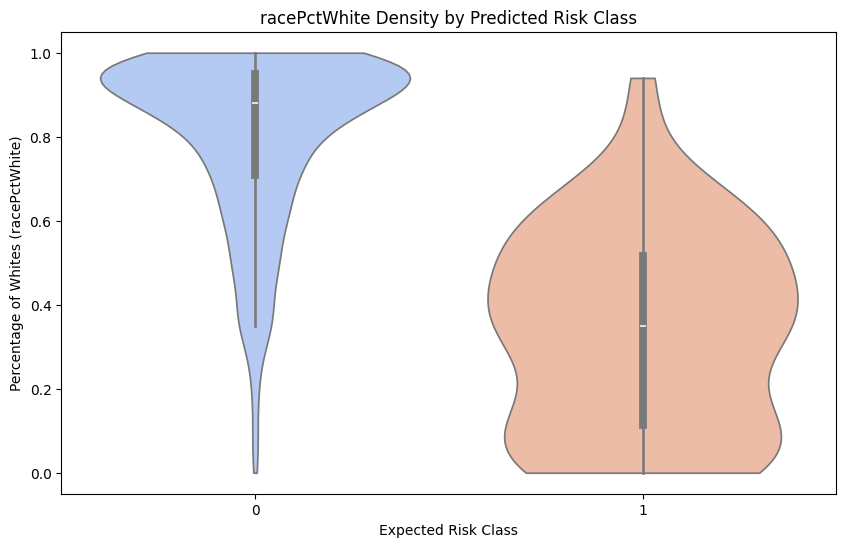

In [ ]:
# Violin plot para análise contínua
plt.figure(figsize=(10, 6))
sns.violinplot(x='y_test_pred', y='racePctWhite', data=X_test_with_preds, palette='coolwarm', cut=0)
plt.title('racePctWhite Density by Predicted Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Whites (racePctWhite)')
plt.show()

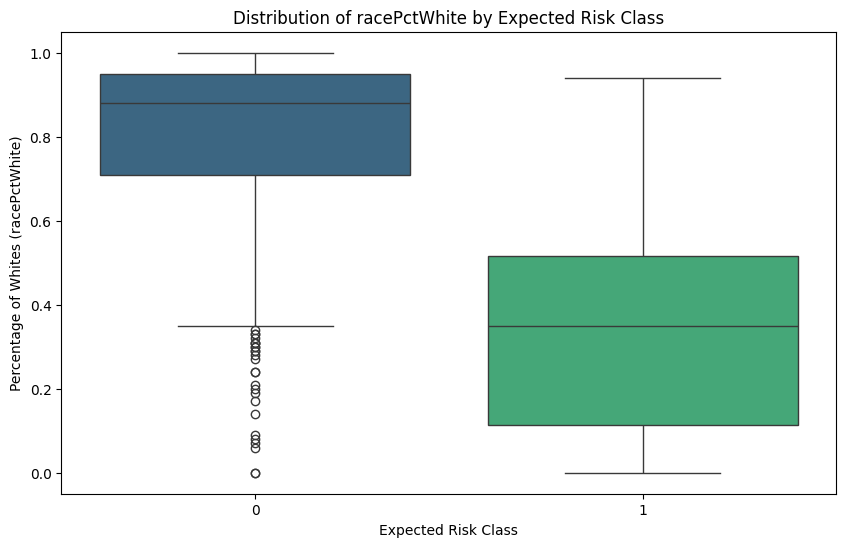

In [ ]:
# Boxplot para distribuição de NonracePctWhite por classe de risco prevista
plt.figure(figsize=(10, 6))
sns.boxplot(x='y_test_pred', y='racePctWhite', data=X_test_with_preds, palette='viridis')
plt.title('Distribution of racePctWhite by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Whites (racePctWhite)')
plt.show()

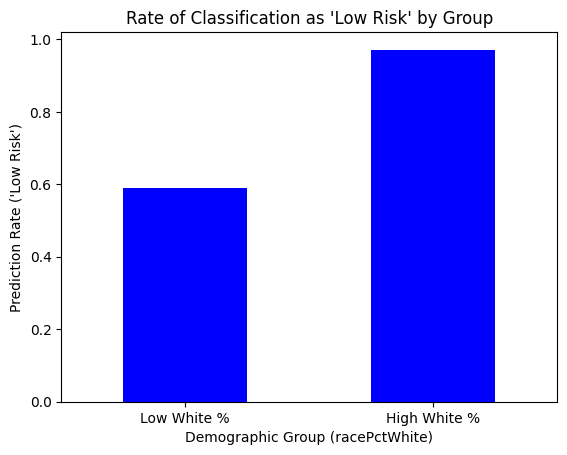

In [ ]:
# Taxa de classificação positiva ("Low Risk") por faixa de racePctWhite
positive_rates = X_test_with_preds.groupby('race_group')['y_test_pred'].apply(lambda x: (x == 0).mean())  # 0 representa 'Low Risk'

# Visualizar as taxas
positive_rates.plot(kind='bar', color='blue')
plt.title("Rate of Classification as 'Low Risk' by Group")
plt.xlabel("Demographic Group (racePctWhite)")
plt.ylabel("Prediction Rate ('Low Risk')")
plt.xticks(rotation=0)
plt.show()

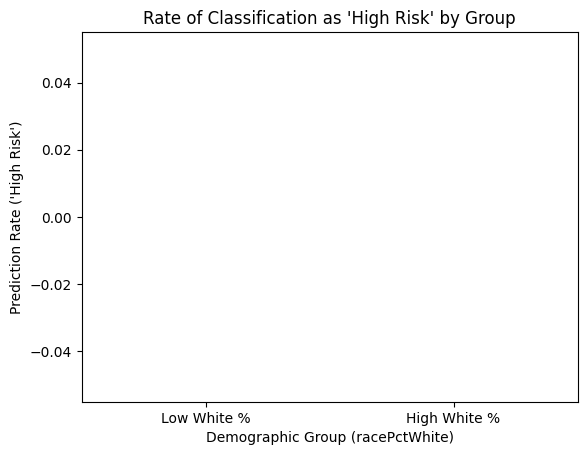

In [ ]:
# Taxa de classificação positiva ("High Risk") por faixa de racePctWhite
high_risk_rates = X_test_with_preds.groupby('race_group')['y_test_pred'].apply(lambda x: (x == 1).mean())  # 1 representa 'High Risk'

# Visualizar as taxas para High Risk
high_risk_rates.plot(kind='bar', color='red')
plt.title("Rate of Classification as 'High Risk' by Group")
plt.xlabel("Demographic Group (racePctWhite)")
plt.ylabel("Prediction Rate ('High Risk')")
plt.xticks(rotation=0)
plt.show()

##### **Family Structure Analysis**

**PctIlleg** - Represents the relative proportion of children born to single mothers in relation to the total number of children in the community.

In [ ]:
X_test_with_preds['illeg_group'] = pd.cut(
    X_test_with_preds['PctIlleg'], 
    bins=[0.0, 0.5, 1.0], 
    labels=['Low Num Childs %', 'High Num Childs %'], 
    include_lowest=True
)

#### Problem overview

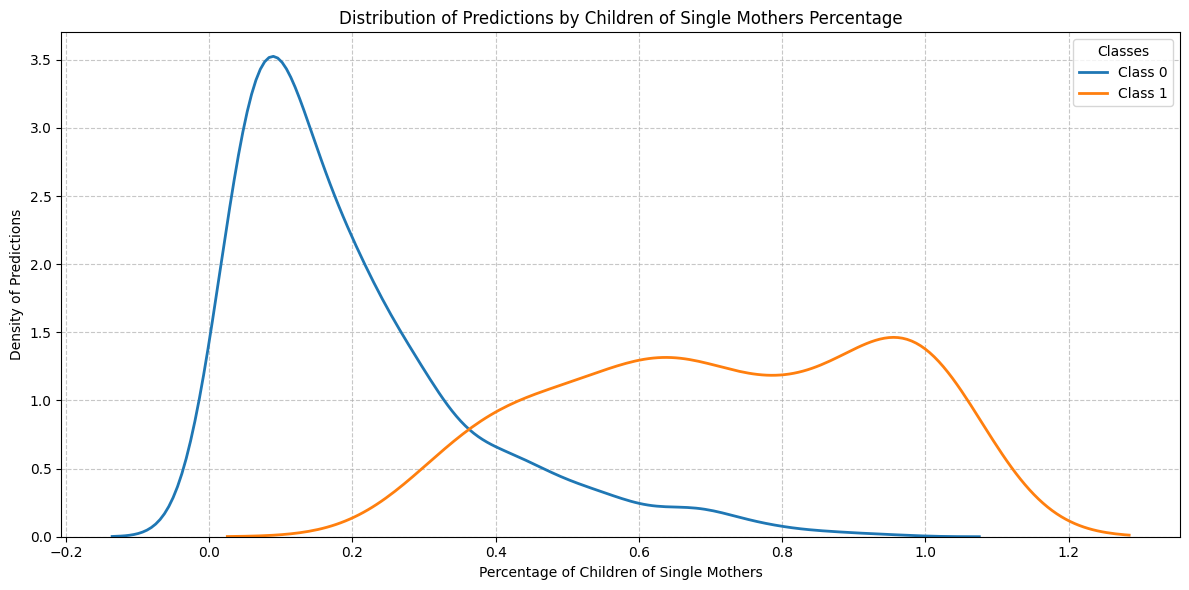

In [ ]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_pred'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_pred'] == cls],
        x="PctIlleg",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of Predictions by Children of Single Mothers Percentage')
plt.xlabel('Percentage of Children of Single Mothers')
plt.ylabel('Density of Predictions')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

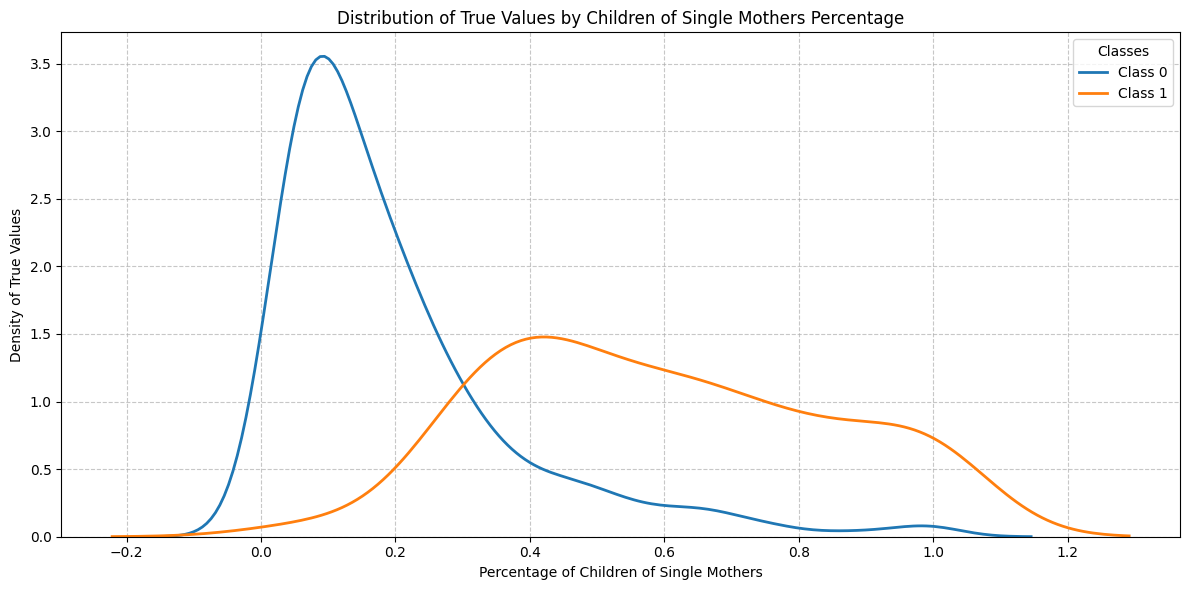

In [ ]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_true'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_true'] == cls],
        x="PctIlleg",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of True Values by Children of Single Mothers Percentage')
plt.xlabel('Percentage of Children of Single Mothers')
plt.ylabel('Density of True Values')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Filtrar os dados para ignorar o grupo "Medium White %"
filtered_groups = ['Low Num Childs %', 'High Num Childs %']
filtered_data = X_test_with_preds[X_test_with_preds['illeg_group'].isin(filtered_groups)]

##### Accuracy Parity

In [ ]:
# Calcular a precisão para cada grupo
accuracy_by_illeg_group = X_test_with_preds.groupby('illeg_group').apply(
    lambda x: (x['y_test_pred'] == x['y_test_true']).mean())
print("Accuracy by Illeg Group:")
print(accuracy_by_illeg_group)

Accuracy by Illeg Group:
illeg_group
Low Num Childs %     0.933237
High Num Childs %    0.651376
dtype: float64


For the group with a low percentage of children born to single mothers ("Low Num Childs %"), the model achieves a high accuracy of 0.9086, indicating good performance in predicting outcomes for this group. However, the accuracy decreases for the "Medium Num Childs %" group, with a value of 0.5738, and continues to drop for the "High Num Childs %" group, where the accuracy is 0.5556. These results suggest that the model struggles more to predict outcomes for communities with higher percentages of children born to single mothers, indicating a potential bias.

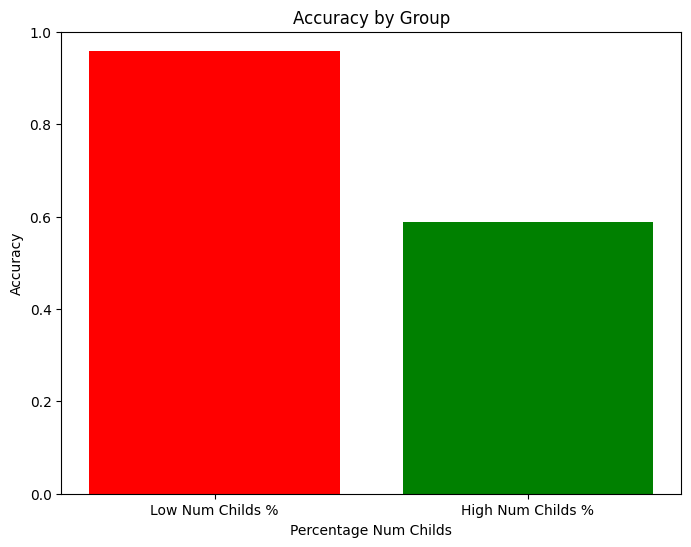

In [ ]:
# Criar gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(filtered_data['illeg_group'].unique(), accuracies, color=['red', 'green'])
plt.xlabel('Percentage Num Childs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Group')
plt.ylim(0, 1)
plt.show()

##### True Positive Rate and False Positive Rate

In [ ]:
# Função para calcular as métricas TPR e FPR para problemas multiclasse
def calculate_metrics(y_true, y_pred, classes_to_consider):
    # Calcular a matriz de confusão usando todas as classes presentes nos dados
    cm = confusion_matrix(y_true, y_pred, labels=classes_to_consider)

    tpr_values = []
    fpr_values = []

    for i, class_label in enumerate(classes_to_consider):
        # TPR: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
        TPR = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) != 0 else 0

        # FPR: Falsos Positivos / (Falsos Positivos + Verdadeiros Negativos)
        FPR = np.sum(cm[:, i]) / np.sum(cm) if np.sum(cm[:, i]) != 0 else 0

        tpr_values.append(TPR)
        fpr_values.append(FPR)

    return tpr_values, fpr_values


# Classes que vamos analisar: 0 e 1
classes_to_consider = [0, 1]

# Inicializando listas para armazenar os valores de TPR e FPR para cada classe
tpr_values = {class_label: [] for class_label in classes_to_consider}
fpr_values = {class_label: [] for class_label in classes_to_consider}

# Calcular TPR e FPR por classe e grupo
for group in filtered_data['illeg_group'].unique():
    group_data = filtered_data[filtered_data['illeg_group'] == group]
    y_true = group_data['y_test_true']
    y_pred = group_data['y_test_pred']

    # Calcular as métricas
    tpr, fpr = calculate_metrics(y_true, y_pred, classes_to_consider)

    # Adicionar os valores das métricas por classe
    for class_label in classes_to_consider:
        tpr_values[class_label].append(tpr[classes_to_consider.index(class_label)])
        fpr_values[class_label].append(fpr[classes_to_consider.index(class_label)])

# Imprimir os resultados de TPR e FPR
for class_label in classes_to_consider:
    print(f"Class {class_label}:")
    for group, tpr, fpr in zip(filtered_data['illeg_group'].unique(), tpr_values[class_label], fpr_values[class_label]):
        print(f"  Group: {group}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

Class 0:
  Group: Low Num Childs %, TPR: 0.9845, FPR: 0.9768
  Group: High Num Childs %, TPR: 0.6327, FPR: 0.4679
Class 1:
  Group: Low Num Childs %, TPR: 0.1429, FPR: 0.0232
  Group: High Num Childs %, TPR: 0.6667, FPR: 0.5321


For **Class 0**:

- The model shows high sensitivity (TPR) in the Low Num Childs % group but makes many errors (high FPR).  
- In the High Num Childs % group, the model is more balanced but still exhibits a lower ability to detect Class 0 (lower TPR).  

For **Class 1**:

- The model is unable to predict Class 1 for the Low Num Childs % group.  
- In the High Num Childs % group, the model performs well in identifying Class 1 (high TPR) but still produces many false positives (high FPR).  

These results suggest that the model exhibits biases and inconsistencies in performance across groups and classes, with greater difficulty in handling communities with a low proportion of children born to single mothers for Class 1 and a tendency to overestimate Class 0 in the Low Num Childs % group.  

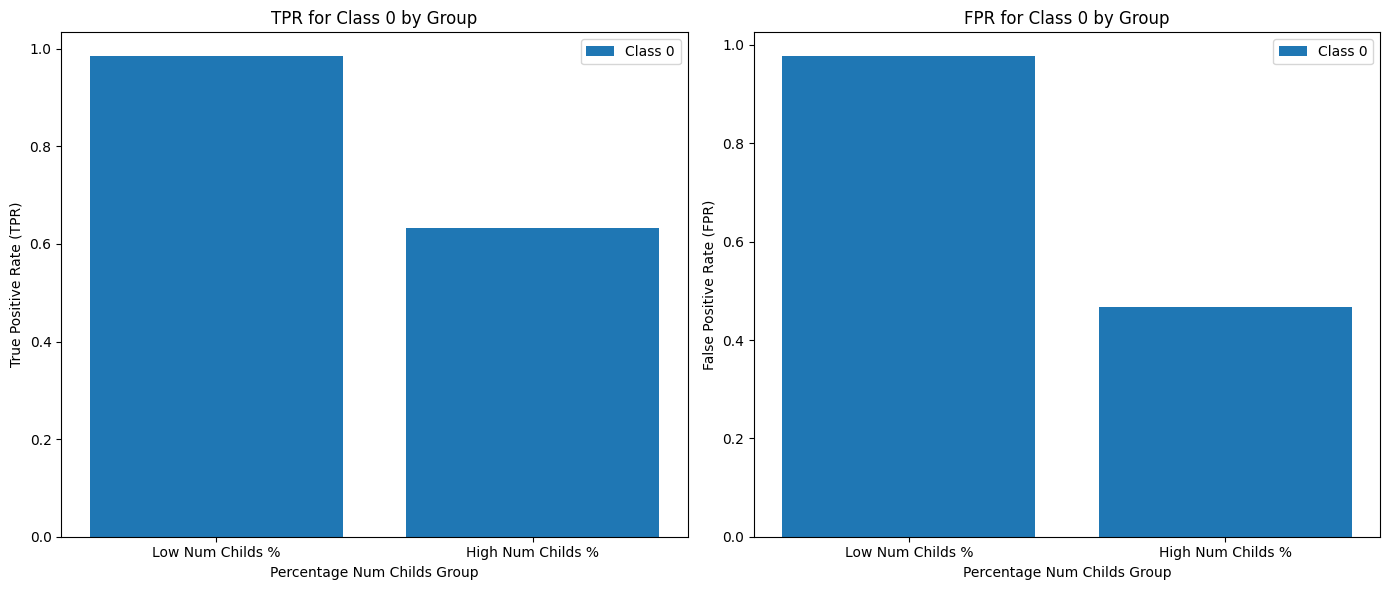

In [ ]:
# Criar gráfico de barras para TPR e FPR por grupo e classe
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 0
axes[0].bar(filtered_data['illeg_group'].unique(), tpr_values[0], label="Class 0")
axes[0].set_xlabel('Percentage Num Childs Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 0 by Group')
axes[0].legend()

# Gráfico de FPR para classe 0
axes[1].bar(filtered_data['illeg_group'].unique(), fpr_values[0], label="Class 0")
axes[1].set_xlabel('Percentage Num Childs Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 0 by Group')
axes[1].legend()
plt.tight_layout()
plt.show()

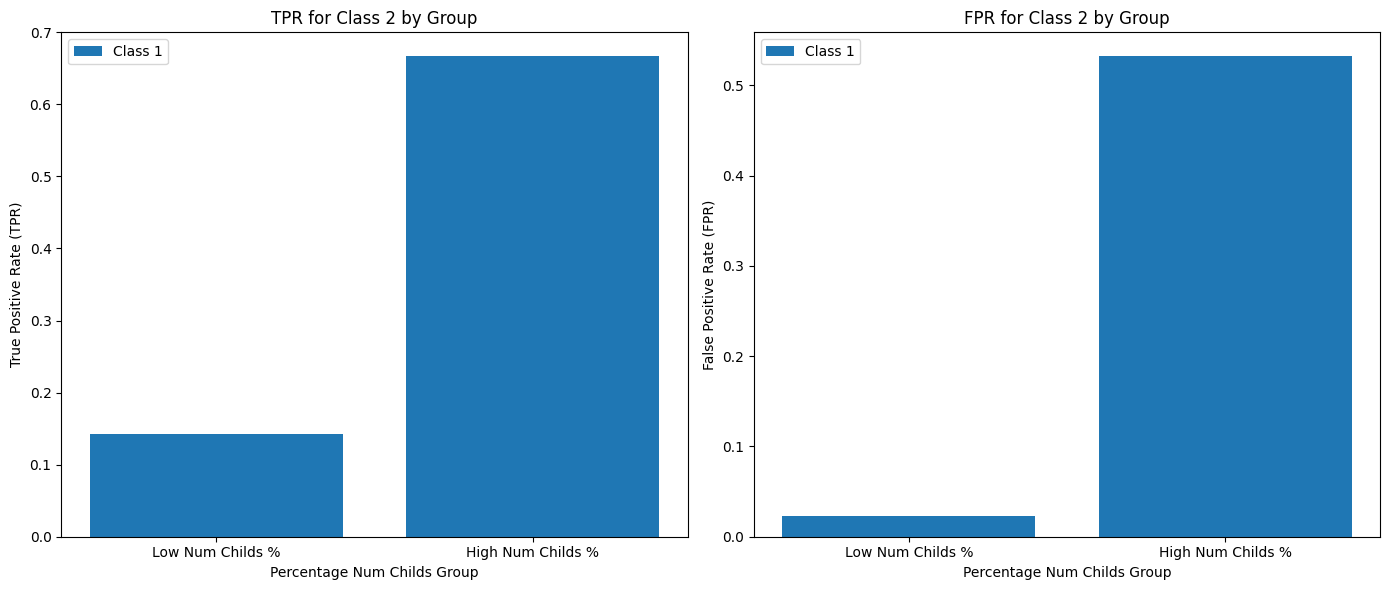

In [ ]:
# Criar gráficos separados para TPR e FPR para a classe 1
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 1
axes[0].bar(filtered_data['illeg_group'].unique(), tpr_values[1], label="Class 1")
axes[0].set_xlabel('Percentage Num Childs Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 1 by Group')
axes[0].legend()

# Gráfico de FPR para classe 1
axes[1].bar(filtered_data['illeg_group'].unique(), fpr_values[1], label="Class 1")
axes[1].set_xlabel('Percentage Num Childs Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 1 by Group')
axes[1].legend()

plt.tight_layout()
plt.show()

##### Disparate Impact

                      LOW-RISK   
Favorable Outcome Rate for High Num Childs %: 0.3492
Favorable Outcome Rate for Low Num Childs %: 0.9983
Disparate Impact: 0.3498


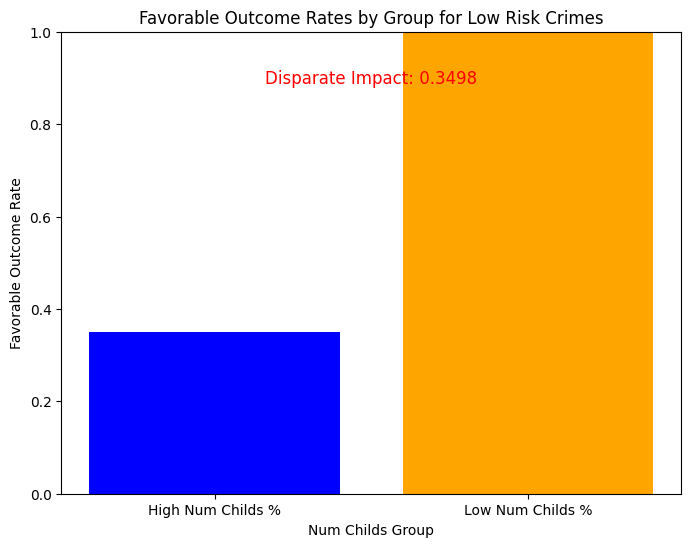

In [ ]:
# Definir os grupos baseados na percentagem de brancos
group_protected = X_test_with_preds[X_test_with_preds['PctIlleg'] > 0.65]
group_non_protected = X_test_with_preds[X_test_with_preds['PctIlleg'] < 0.35]

# Definir o resultado favorável (classe "low risk" = 0)
favorable_outcome = 0

# Calcular a proporção de resultados favoráveis para cada grupo
protected_favorable_rate = (group_protected['y_test_pred'] == favorable_outcome).mean()
non_protected_favorable_rate = (group_non_protected['y_test_pred'] == favorable_outcome).mean()

# Calcular o Disparate Impact
disparate_impact = protected_favorable_rate / non_protected_favorable_rate if non_protected_favorable_rate > 0 else 0

# Exibir os resultados
print("                      LOW-RISK   ")
print(f"Favorable Outcome Rate for High Num Childs %: {protected_favorable_rate:.4f}")
print(f"Favorable Outcome Rate for Low Num Childs %: {non_protected_favorable_rate:.4f}")
print(f"Disparate Impact: {disparate_impact:.4f}")
# Data for visualization
groups = ['High Num Childs %', 'Low Num Childs %']
favorable_rates = [protected_favorable_rate, non_protected_favorable_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, favorable_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for Low Risk Crimes')
plt.xlabel('Num Childs Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 0.2077**

**For Low-Risk:**

The favorable outcome rate for the High Num Childs % group is 0.2063, indicating that only 20.63% of the cases in this group are classified as low risk. In contrast, the Low Num Childs % group has a favorable outcome rate of 0.9934, meaning that nearly all cases in this group are classified as low risk. The Disparate Impact is 0.2077, showing a significant disparity between the two groups. The model is much less likely to classify communities with a higher percentage of children born to single mothers as low risk, highlighting a potential bias that favors communities with a lower proportion of this characteristic.

                      HIGH-RISK   
Favorable Outcome Rate for High Num Childs %: 0.6508
Favorable Outcome Rate for Low Num Childs %: 0.0017
Disparate Impact (High Risk): 394.3810


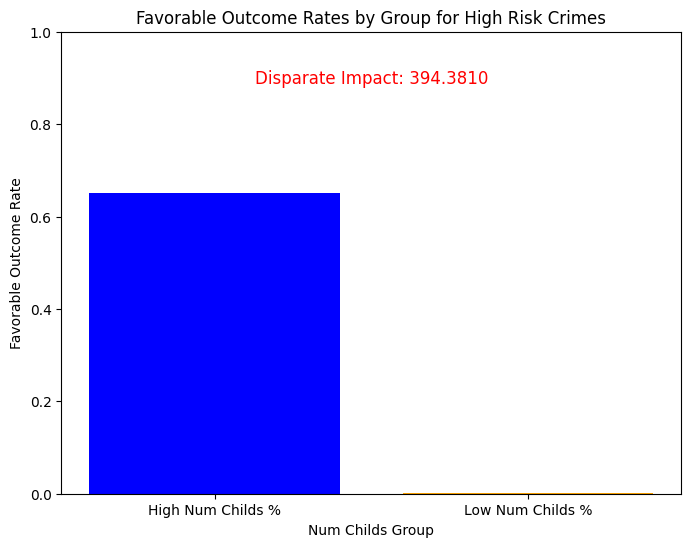

In [ ]:
# Definir grupos de High Risk
high_risk_class = 1  # Classe "high risk" (assumindo que a classe 1 representa high risk)

# Identificar os grupos baseados na racePctWhite
group_high_child = X_test_with_preds[X_test_with_preds['PctIlleg'] > 0.65]
group_low_child = X_test_with_preds[X_test_with_preds['PctIlleg'] < 0.35]

# Calcular as taxas de resultado favorável para o grupo High Risk
high_white_high_risk_rate = (group_high_child['y_test_pred'] == high_risk_class).mean()
low_white_high_risk_rate = (group_low_child['y_test_pred'] == high_risk_class).mean()

# Calcular o Disparate Impact (DI)
disparate_impact_high_risk = high_white_high_risk_rate / low_white_high_risk_rate

# Exibir os resultados
print("                      HIGH-RISK   ")
print(f"Favorable Outcome Rate for High Num Childs %: {high_white_high_risk_rate:.4f}")
print(f"Favorable Outcome Rate for Low Num Childs %: {low_white_high_risk_rate:.4f}")
print(f"Disparate Impact (High Risk): {disparate_impact_high_risk:.4f}")
# Data for visualization
groups = ['High Num Childs %', 'Low Num Childs %']
high_risk_rates = [high_white_high_risk_rate, low_white_high_risk_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, high_risk_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for High Risk Crimes')
plt.xlabel('Num Childs Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact_high_risk:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 250.0953**

**For High-Risk:**

The favorable outcome rate for the High Num Childs % group is 0.4127, indicating that 41.27% of the cases in this group are classified as high risk. In contrast, the Low Num Childs % group has a favorable outcome rate of 0.0017, meaning that only 0.17% of cases in this group are classified as high risk. The Disparate Impact is 250.0952, revealing a significant disparity between the two groups. The model is much more likely to classify communities with a higher percentage of children born to single mothers as high risk, while the model almost entirely excludes such classification in communities with a lower proportion of this characteristic. This highlights a strong bias in the model, with a pronounced tendency to favor the High Num Childs % group in predicting high-risk outcomes.

#### Fairness Visualization

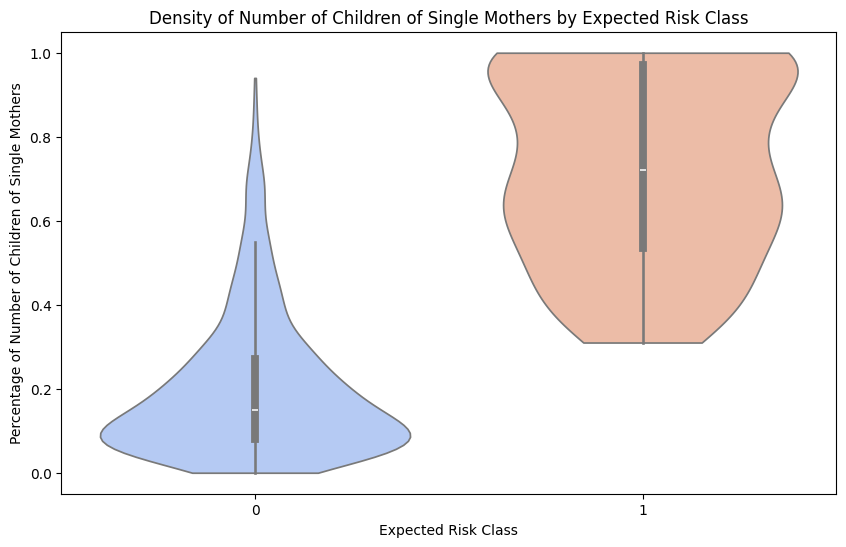

In [ ]:
# Violin plot para análise contínua
plt.figure(figsize=(10, 6))
sns.violinplot(x='y_test_pred', y='PctIlleg', data=X_test_with_preds, palette='coolwarm', cut=0)
plt.title('Density of Number of Children of Single Mothers by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Number of Children of Single Mothers')
plt.show()

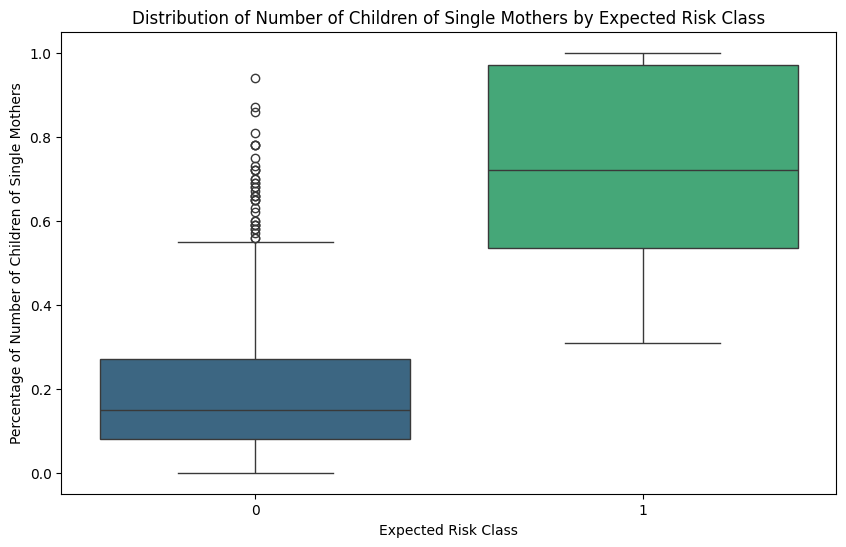

In [ ]:
# Boxplot para distribuição de NonracePctWhite por classe de risco prevista
plt.figure(figsize=(10, 6))
sns.boxplot(x='y_test_pred', y='PctIlleg', data=X_test_with_preds, palette='viridis')
plt.title('Distribution of Number of Children of Single Mothers by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Number of Children of Single Mothers')
plt.show()

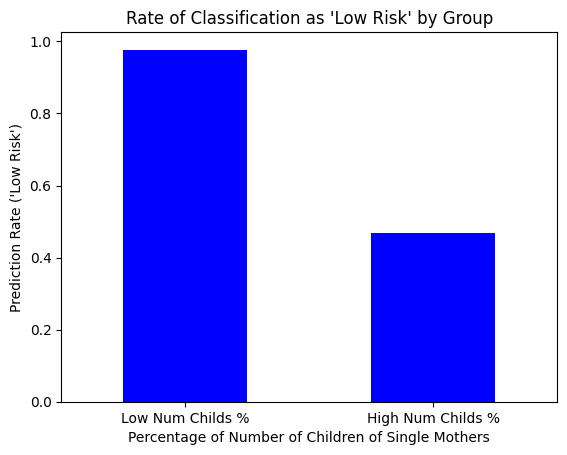

In [ ]:
# Taxa de classificação positiva ("Low Risk") por faixa de racePctWhite
positive_rates = X_test_with_preds.groupby('illeg_group')['y_test_pred'].apply(
    lambda x: (x == 0).mean())  # 0 representa 'Low Risk'

# Visualizar as taxas
positive_rates.plot(kind='bar', color='blue')
plt.title("Rate of Classification as 'Low Risk' by Group")
plt.xlabel("Percentage of Number of Children of Single Mothers")
plt.ylabel("Prediction Rate ('Low Risk')")
plt.xticks(rotation=0)
plt.show()

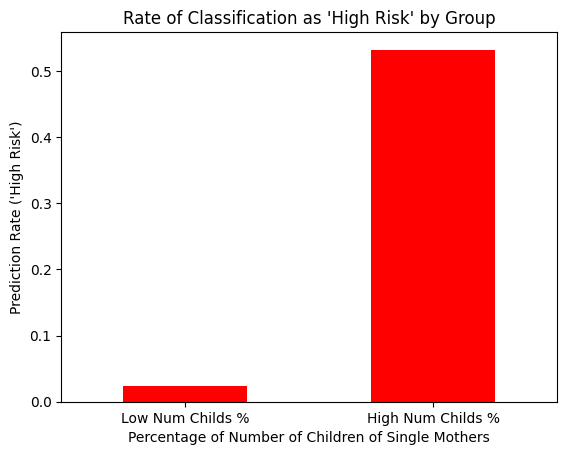

In [ ]:
# Taxa de classificação positiva ("High Risk") por faixa de racePctWhite
high_risk_rates = X_test_with_preds.groupby('illeg_group')['y_test_pred'].apply(
    lambda x: (x == 1).mean())  # 1 representa 'High Risk'

# Visualizar as taxas para High Risk
high_risk_rates.plot(kind='bar', color='red')
plt.title("Rate of Classification as 'High Risk' by Group")
plt.xlabel("Percentage of Number of Children of Single Mothers")
plt.ylabel("Prediction Rate ('High Risk')")
plt.xticks(rotation=0)
plt.show()